# Práctica de clasificación

## Autoría

* Nombre: Jorge Cabrera Rodríguez
* Email: alu0101351773@ull.edu.es
* Universidad: Universidad de La Laguna
* Máster: Ciberseguridad e Inteligencia de Datos
* Repositorio: [enlace](https://github.com/alu0101351773/ECBD_practicas.git)

## Introducción al _dataset_

Este proyecto trbaja con una base de datos llamada `homeLoanAproval.csv`, que
contiene información detallada sobre los créditos bancarios concedidos a 614
usuarios de una entidad bancaria desconocida. Esta base de datos cuenta con
valores como puedan ser, entre otros:

* El estado civil del usuario (`Married`)
* EL nivel educativo del solicitante (`Education`)
* El importe del crédito solicitado (`LoanAmount`)
* El número de personas que dependan del solicitante (`Dependents`)
* El estado del crédito (`Loan_Status`) (Aprobado o denegado)

Con esta base de datos se busca construir un sistema que sea capaz de ayudar en
la tarea de concesión de créditos bancarios para futuros usuarios, de tal forma
que para unos datos de entrada desconocidos para el sistema, este sea capaz de
predecir si el crédito será aprobado o denegado.

## Desarrollo del proyecto

### Visualización de datos

#### Carga de datos

La primera tarea a realizar con la base de datos es realizar una visualización
inicial, para observar los datos con los que trabajamos, así como sus deficiencias
y posibles problemas que puedan surgir.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv('../data/Base de datos - homeLoanAproval.csv')
dataset.head()

,Loan_ID,Gender,Married,Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,PropertyArea,LoanStatus
0,LP001002,Male,No,0,Graduate,No,5849,0,NaN,360.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508,128.0,360.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0,66.0,360.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358,120.0,360.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0,141.0,360.0,Urban,Y


In [3]:
print(f'Tamaño del dataset: {dataset.shape}')

Tamaño del dataset: (614, 12)


En la primera visualización podemos observar que el dataset cuenta con 614
registros y 12 variables por cada registro. De estas 12 variables, 11 son
variables de entrada y 1 es la variable de salida, que es la que se pretende
predecir (`LoanStatus`).

#### Recuento de valores nulos

Contaremos el número de valores
nulos que contiene cada variable, con el objetivo de analizar si es necesario
realizar algún tipo de tratamiento de datos para eliminar estos valores nulos.

In [4]:
pd.DataFrame.from_dict(
    data = {
        'Tipo de dato': dataset.dtypes,
        'Valores faltantes (NA)': dataset.isna().sum(),
    },
    orient = 'columns'
)

,Tipo de dato,Valores faltantes (NA)
Loan_ID,object,0
Gender,object,13
Married,object,3
Dependents,object,15
Education,object,0
SelfEmployed,object,32
ApplicantIncome,int64,0
CoapplicantIncome,object,0
LoanAmount,float64,22
LoanAmountTerm,float64,14


Podemos observar que la base de datos cuenta con bastantes valores nulos, por lo
que será necesario algún tipo de preprocesado para poder reducir su número.

#### Análisis de valores atípicos

Además de los valores nulos, también es necesario analizar los valores atípicos
(_outliers_) que puedan existir en la base de datos. Para ello, se ha realizado
un análisis de los valores atípicos de las variables numéricas, que son las
siguientes:

* `ApplicantIncome`
* `LoanAmount`
* `LoanAmountTerm`

Para este análisis, se ha utilizado el diagrama de cajas (_boxplot_), que nos
permite observar los valores atípicos de una variable de forma visual.

Text(0.5, 1.0, 'LoanAmountTerm')

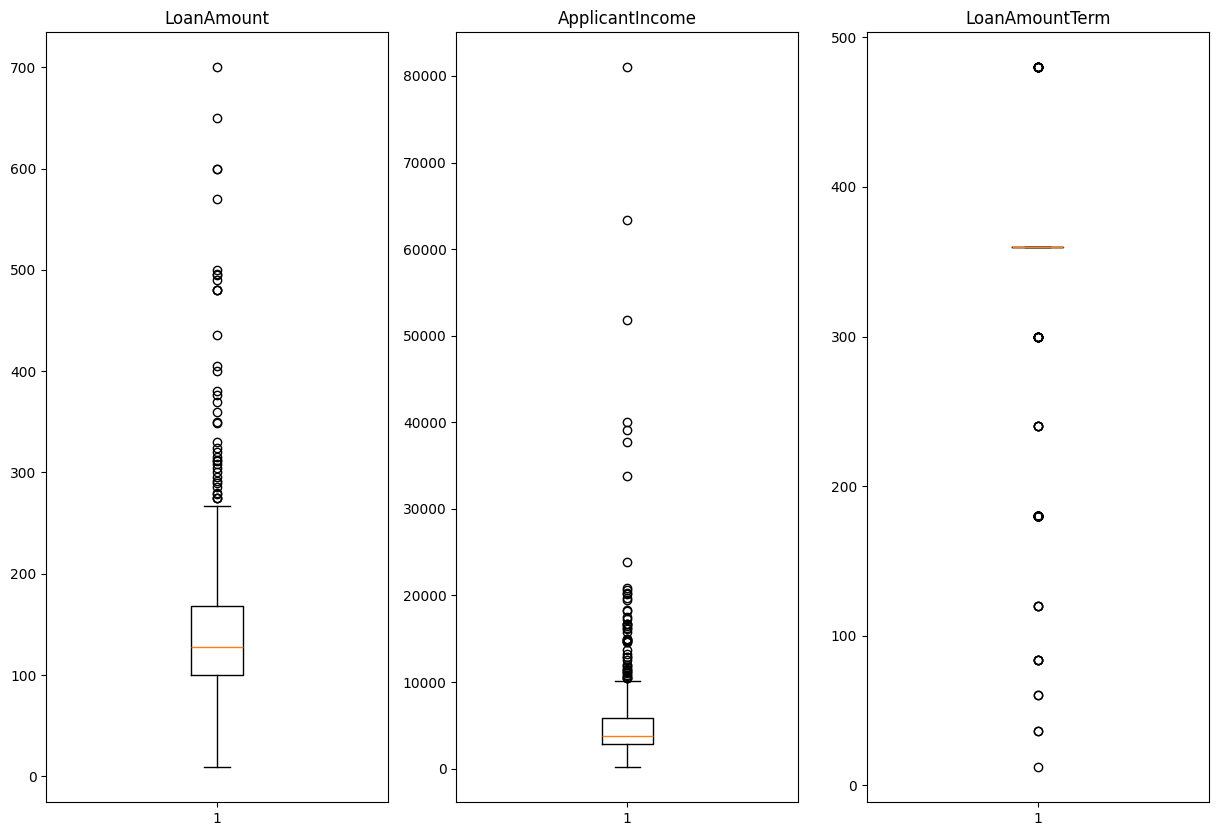

In [5]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 10))

ax[0].boxplot(dataset['LoanAmount'].dropna())
ax[0].set_title('LoanAmount')

ax[1].boxplot(dataset['ApplicantIncome'])
ax[1].set_title('ApplicantIncome')

ax[2].boxplot(dataset['LoanAmountTerm'].dropna())
ax[2].set_title('LoanAmountTerm')

Según se puede observar, la variable `CoapplicantIncome` no se ha incluido en
el análisis de outliers, pues aunque contenga números, estos están expresados
como cadenas de texto, por lo que se debe analizar únicamente tras haber
realizado el preprocesado de datos.

Para corregir esta variable antes de comenzar el preproceasdo persé, se
realizará una pequeña limpieza de datos en la que se formateará la variable a
números, eliminando puntos y comas, y convirtiendo la variable a tipo numérico.

Text(0.5, 1.0, 'CoapplicantIncome')

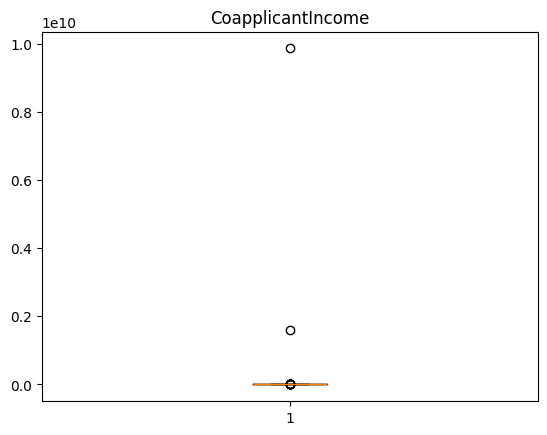

In [6]:
if dataset['CoapplicantIncome'].dtype is not np.dtype('int64'):
    dataset['CoapplicantIncome'] = dataset['CoapplicantIncome'].apply(lambda x: int(x.replace('.', '')))

fig, ax = plt.subplots()

ax.boxplot(dataset['CoapplicantIncome'])
ax.set_title('CoapplicantIncome')

Como se observa en el diagrama de cajas de la variable `CoapplicantIncome`, esta
cuenta con pocos valores atípicos, pero muy alejados del promedio de valores, lo
que podrá (y seguramente lo hará) afectar al modelo de clasificación generado.

#### Balance de clases

Como último paso de visualización de datos, puede ser interesante analizar el
balance de clases de la variable de salida `LoanStatus`, para observar si
existe un desbalance que pueda afectar al modelo de clasificación.

In [7]:
pd.DataFrame.from_dict(
    data = {
        'Registros': dataset['LoanStatus'].value_counts(),
        'Porcentaje (%)': dataset['LoanStatus'].value_counts(normalize = True).apply(lambda x: round(x * 100, 2)),
    },
    orient = 'columns'
)

,Registros,Porcentaje (%)
LoanStatus,,
Y,422,68.73
N,192,31.27


Podemos observar un desbalance de clases moderado, pues casi un 70% de las
entradas pertenecen a la clase de créditos aprobados (`Y`), mientras que el
resto pertenecen a la clase de créditos denegados (`N`).

Siendo un desbalance no tan marcado, es probable que no influya demasiado en el
modelo de clasificación. Sin embargo, sería interesante más adelante realizar un
entrenamiento del modelo con y sin balanceo de clases, para observar si existe
alguna mejora en el rendimiento del mismo.

### Preprocesado de datos

#### Eliminación de variables innecesarias

El primer paso de la fase de preprocesado será la eliminación de aquellas
variables que no aporten información al modelo, o sean irrelevantes por su
propia naturaleza.

En este caso en particular, todas las variables aportan información sobre los
clientes que puede ser relevante; todas menos la variable `LoanID`, pues es un
valor serial que se genera de forma automática para cada registro, y no aporta
ninguna información útil para un modelo de clasificación.

In [8]:
if 'Loan_ID' in dataset.columns:
    dataset.drop(columns = ['Loan_ID'], inplace = True)
dataset.head()

,Gender,Married,Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,PropertyArea,LoanStatus
0,Male,No,0,Graduate,No,5849,0,NaN,360.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508,128.0,360.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0,66.0,360.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358,120.0,360.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0,141.0,360.0,Urban,Y


#### Corrección de valores faltantes

Tras haber eliminado las variables innecesarias, se procederá a corregir los
valores faltantes de las variables restantes. Para esto, generaremos dos
conjuntos de datos, uno con los valores faltantes eliminados, y otro con los
valores faltantes completados mediante técnicas tales como:

* Media de los valores de la variable
* Mediana de los valores de la variable
* Moda de los valores de la variable
* Media de los valores dependiendo de otra variable

El primer paso en esta fase es la eliminación de los valores faltantes:

In [9]:
trimmed_dataset = dataset.dropna().copy(deep = True)

pd.DataFrame.from_dict(
    data = {
        'Valores faltantes (NA)': trimmed_dataset.isna().sum(),
    },
    orient = 'columns'
)

,Valores faltantes (NA)
Gender,0
Married,0
Dependents,0
Education,0
SelfEmployed,0
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
LoanAmountTerm,0
PropertyArea,0


El siguiente paso es rellenar todos los campos faltantes, dependiendo del tipo
de dato y de su naturaleza, pues no todos los datos se pueden rellenar de la
misma forma:

* Los datos no numéricos se pueden rellenar según la moda de sus valores,
pero no según la media ni la mediana, pues no podemos realizar los cálculos de
promedio sobre ellos.
* Los datos numéricos se pueden rellenar tanto con la media como con la
moda o la mediana.
    * Sin embargo, si contienen valores anómalos (outliers), es mejor rellenar
    con la mediana, pues esta se ve menos afectada por los valores anómalos.

En este proyecto, los valores a rellenar son los siguientes:

* `Gender`
* `Married`
* `Dependents`
* `SelfEmployed`
* `LoanAmount`
* `LoanAmountTerm`

##### Campo `Gender`

El género es una variable cualitativa, por lo que se rellenará con la moda de sus
valores respecto al valor de la variable `LoanStatus`.

In [10]:
filled_dataset = dataset.copy()
print(f'Valores de \'Gender\' nulos: {filled_dataset["Gender"].isna().sum()}')

Valores de 'Gender' nulos: 13


In [11]:
# Calculamos la moda de 'Gender' para cada 'LoanStatus'
loan_status_mode = filled_dataset.groupby('LoanStatus')['Gender'].value_counts()
loan_status_mode

LoanStatus  Gender
N           Male      150
            Female     37
Y           Male      339
            Female     75
Name: count, dtype: int64

Podemos observar en ambos `LoanStatus` que la moda es `Male`, pues su proporción
de valores es mayor. Este será, por tanto, el valor a rellenar,
independientemente del valor del `LoanStatus` pues en ambos es mayoría.

In [12]:
# Calculo del genero modal
modal_gender = loan_status_mode.groupby('LoanStatus').apply(lambda x: x.index[0][1]).iloc[0]
modal_gender

# Rellenado de valores nulos
filled_dataset['Gender'].fillna(modal_gender, inplace = True)

print(f'Valores de \'Gender\' nulos: {filled_dataset["Gender"].isna().sum()}')

Valores de 'Gender' nulos: 0


##### Campo `Married`

Para el campo `Married` se realizará la misma operación que para el campo
`Gender`, pues ambos son variables cualitativas.

In [13]:
marital_status = filled_dataset.groupby('LoanStatus')['Married'].value_counts()
marital_status

LoanStatus  Married
N           Yes        113
            No          79
Y           Yes        285
            No         134
Name: count, dtype: int64

De manera similar al campo `Gender`, el valor `Yes` es mayoritario en ambos
valores de `LoanStatus`, por lo que será el valor a rellenar.

In [14]:
# Calculo del estado civil modal
modal_marital_status = marital_status.groupby('LoanStatus').apply(lambda x: x.index[0][1]).iloc[0]
modal_marital_status

# Rellenado de valores nulos
filled_dataset['Married'].fillna(modal_marital_status, inplace = True)

print(f'Valores de \'Married\' nulos: {filled_dataset["Married"].isna().sum()}')

Valores de 'Married' nulos: 0


##### Campo `Dependents`

Esta variable también es cualitativa, por lo que se rellenará con la moda de sus
valores respecto al valor de la variable `LoanStatus`.

In [15]:
dependent_status = filled_dataset.groupby('LoanStatus')['Dependents'].value_counts()
dependent_status

LoanStatus  Dependents
N           0             107
            1              36
            2              25
            3+             18
Y           0             238
            2              76
            1              66
            3+             33
Name: count, dtype: int64

Se vuelve a dar el caso de que en ambos valores de `LoanStatus` la moda es
`0`, por lo que este será el valor a rellenar en ambos casos.

In [16]:
# Calculo del 'depenants' modal
modal_dependent_status = dependent_status.groupby('LoanStatus').apply(lambda x: x.index[0][1]).iloc[0]

# Rellenado de valores nulos
filled_dataset['Dependents'].fillna(modal_dependent_status, inplace = True)
filled_dataset['Dependents'] = filled_dataset['Dependents'].astype('object')

print(f'Valores de \'Dependents\' nulos: {filled_dataset["Dependents"].isna().sum()}')

Valores de 'Dependents' nulos: 0


##### Campo `SelfEmployed`

Continuamos con otra variable cualitativa como sea `SelfEmployed`, repitiendo el
proceso de rellenado de valores.

In [17]:
employed_status = filled_dataset.groupby('LoanStatus')['SelfEmployed'].value_counts()
employed_status

LoanStatus  SelfEmployed
N           No              157
            Yes              26
Y           No              343
            Yes              56
Name: count, dtype: int64

In [18]:
modal_employee_status = employed_status.groupby('LoanStatus').apply(lambda x: x.index[0][1]).iloc[0]

filled_dataset['SelfEmployed'].fillna(modal_employee_status, inplace = True)

print(f'Valores de \'SelfEmployed\' nulos: {filled_dataset["SelfEmployed"].isna().sum()}')

Valores de 'SelfEmployed' nulos: 0


##### Campos `LoanAmount` y `LoanAmountTerm`

Tanto los campos `LoanAmount` como `LoanAmountTerm` son variables numéricas, por
lo que debemos aplicar técnicas basadas en media o mediana, preferiblemente.

Como podemos observar en el gráfico del apartado *Análisis de valores atípicos*,
ambas variables cuentan con valores atípicos, por lo que es preferible rellenar
utilizando la mediana.

In [19]:
median_loan_amount = filled_dataset['LoanAmount'].median()
median_loan_amount_term = filled_dataset['LoanAmountTerm'].median()

print(f'Mediana de \'LoanAmount\': {median_loan_amount}')
print(f'Mediana de \'LoanAmountTerm\': {median_loan_amount_term}')

Mediana de 'LoanAmount': 128.0
Mediana de 'LoanAmountTerm': 360.0


In [20]:
filled_dataset['LoanAmount'].fillna(median_loan_amount, inplace = True)
filled_dataset['LoanAmountTerm'].fillna(median_loan_amount_term, inplace = True)

print(f'Valores de \'LoanAmount\' nulos: {filled_dataset["LoanAmount"].isna().sum()}')
print(f'Valores de \'LoanAmountTerm\' nulos: {filled_dataset["LoanAmountTerm"].isna().sum()}')

Valores de 'LoanAmount' nulos: 0
Valores de 'LoanAmountTerm' nulos: 0


Después de haber completado todas las variables con valores faltantes, podemos
ver en la siguiente tabla como todos los registros se encuentran ahora
completos.

In [21]:
pd.DataFrame.from_dict(
    data = {
        'Valores faltantes (NA)': filled_dataset.isna().sum(),
    },
    orient = 'columns'
)

,Valores faltantes (NA)
Gender,0
Married,0
Dependents,0
Education,0
SelfEmployed,0
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
LoanAmountTerm,0
PropertyArea,0


#### Etiquetado

Para aquellas variables cualitativas que no sean binarias, se realizará un
etiquetado de los valores, de tal forma que se conviertan en valores numéricos
que puedan ser utilizados por el modelo de clasificación.

##### Etiquetado en `filled_dataset`

In [22]:
from sklearn.preprocessing import LabelEncoder

encoders_dict = {}

unlabeled_cols = [col for col in filled_dataset.columns if filled_dataset[col].dtype == 'object']
numeric_cols = [col for col in filled_dataset.columns if filled_dataset[col].dtype != 'object']

for col in unlabeled_cols:
    encoders_dict[col] = LabelEncoder()
    filled_dataset[col] = encoders_dict[col].fit_transform(filled_dataset[col])

filled_dataset.head()

,Gender,Married,Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,PropertyArea,LoanStatus
0,1,0,0,0,0,5849,0,128.0,360.0,2,1
1,1,1,1,0,0,4583,1508,128.0,360.0,0,0
2,1,1,0,0,1,3000,0,66.0,360.0,2,1
3,1,1,0,1,0,2583,2358,120.0,360.0,2,1
4,1,0,0,0,0,6000,0,141.0,360.0,2,1


##### Etiquetado en `trimmed_dataset`

In [23]:
encoders_dict_tr = {}

for col in unlabeled_cols:
    encoders_dict_tr[col] = LabelEncoder()
    trimmed_dataset[col] = encoders_dict_tr[col].fit_transform(trimmed_dataset[col])

trimmed_dataset.head()

,Gender,Married,Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,PropertyArea,LoanStatus
1,1,1,1,0,0,4583,1508,128.0,360.0,0,0
2,1,1,0,0,1,3000,0,66.0,360.0,2,1
3,1,1,0,1,0,2583,2358,120.0,360.0,2,1
4,1,0,0,0,0,6000,0,141.0,360.0,2,1
5,1,1,2,0,1,5417,4196,267.0,360.0,2,1


#### Corrección de _outliers_

Para la corrección de _outliers_ voy a eliminar todos aquellos valores a partir
del valor calculado por el diagrama de cajas, que es el valor de la mediana más
1.5 veces el rango intercuartílico.

En esta corrección, se eliminarán todos los valores atípicos menos los
relacionados con `LoanAmountTerm`, pues al ser un campo tan concentrado
alrededor del valor 360 (como se observa en el apartado de visualización de
datos), nos quedaría una columna con únicamente un valor, lo que no aportaría
información alguna al problema.

In [24]:
def calc_outliers(dataset: pd.DataFrame, variable: str) -> tuple:
    intercuartial_range = dataset[variable].quantile(0.75) - dataset[variable].quantile(0.25)
    return (
        dataset[variable].quantile(0.25) - 1.5 * intercuartial_range,
        dataset[variable].quantile(0.75) + 1.5 * intercuartial_range,
    )

outlier_thresholds = {
    "LoanAmount": calc_outliers(filled_dataset, 'LoanAmount'),
    "ApplicantIncome": calc_outliers(filled_dataset, 'ApplicantIncome'),
    # "LoanAmountTerm": calc_outliers(filled_dataset, 'LoanAmountTerm'),
    "CoapplicantIncome": calc_outliers(filled_dataset, 'CoapplicantIncome')
}

print(f'''
    Umbral de \'LoanAmount\': {outlier_thresholds['LoanAmount']}
    Umbral de \'ApplicantIncome\': {outlier_thresholds['ApplicantIncome']}
    Umbral de \'CoapplicantIncome\': {outlier_thresholds['CoapplicantIncome']}
''')
# print(f'Umbral de \'LoanAmountTerm\': {outlier_thresholds["LoanAmountTerm"]}')


    Umbral de 'LoanAmount': (3.5, 261.5)
    Umbral de 'ApplicantIncome': (-1498.75, 10171.25)
    Umbral de 'CoapplicantIncome': (-3486.0, 5810.0)



Una vez calculados los umbrales a partir de los cuales se considerará un valor
_outlier_, se eliminarán aquellas celdas que contengan valores superiores (o
inferiores) a los umbrales designados.

In [25]:
for variable in outlier_thresholds.keys():
    filled_dataset = filled_dataset[
        (filled_dataset[variable] >= outlier_thresholds[variable][0]) &
        (filled_dataset[variable] <= outlier_thresholds[variable][1])
    ]

Text(0.5, 1.0, 'CoapplicantIncome')

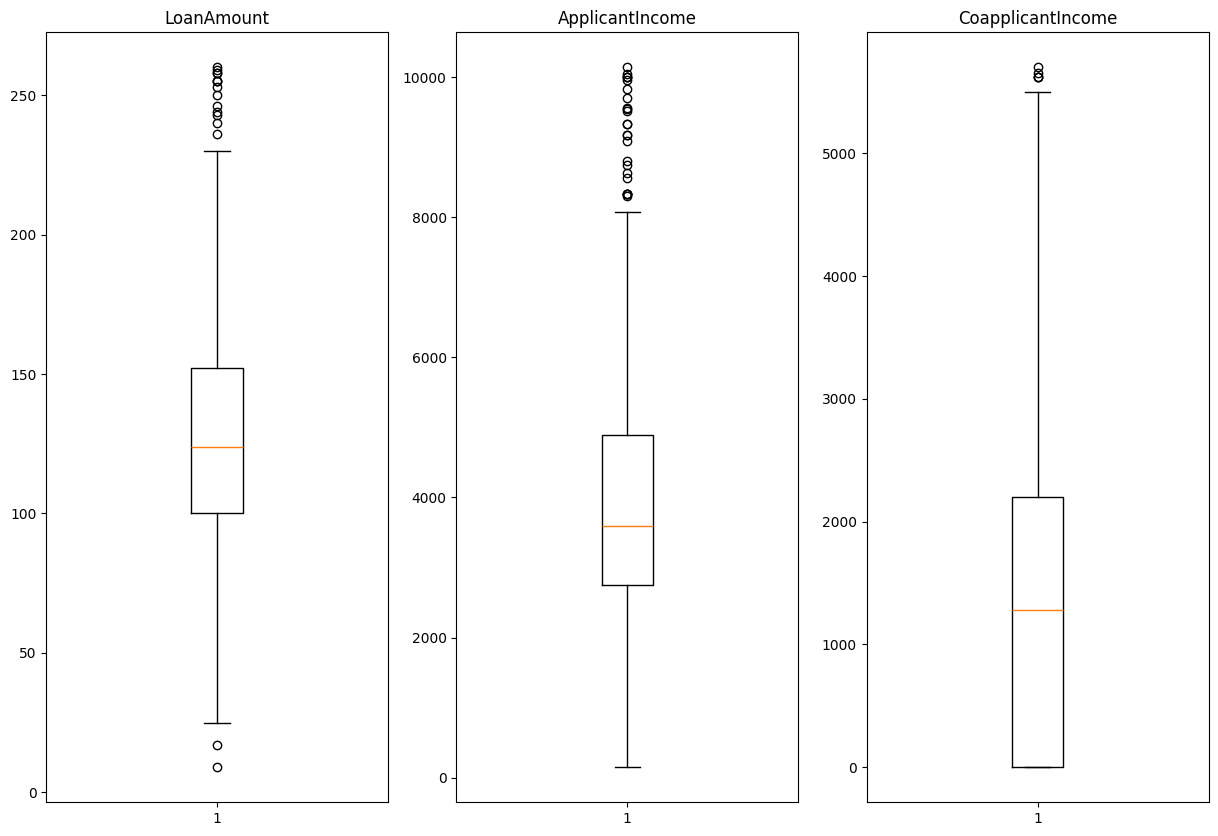

In [26]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 10))

ax[0].boxplot(filled_dataset['LoanAmount'].dropna())
ax[0].set_title('LoanAmount')

ax[1].boxplot(filled_dataset['ApplicantIncome'])
ax[1].set_title('ApplicantIncome')

ax[2].boxplot(filled_dataset['CoapplicantIncome'])
ax[2].set_title('CoapplicantIncome')

Como se puede observar, se han eliminado gran parte de los registros que
contenían valores _outliers_ a partir de los umbrales calculados. Los _outliers_
actuales son aquellos puntos que originalmente se contaban como valores
ordinarios, pero por el hecho de haber eliminado otros valores, ahora se
reconsideran como _outlayers_.

En este proyecto se conservará esta "segunda generación" de _outliers_, pues ya
se ha realizado suficiente limpieza.

#### Normalización de los datos

Una vez preprocesados, formateados y limpiados los datos, se procederá a
normalizarlos, para que todos los valores se encuentren en un rango similar y
no haya valores que puedan afectar al modelo de clasificación.

##### Normalizado de `filled_dataset`

In [27]:
filled_dataset.head()

,Gender,Married,Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,PropertyArea,LoanStatus
0,1,0,0,0,0,5849,0,128.0,360.0,2,1
1,1,1,1,0,0,4583,1508,128.0,360.0,0,0
2,1,1,0,0,1,3000,0,66.0,360.0,2,1
3,1,1,0,1,0,2583,2358,120.0,360.0,2,1
4,1,0,0,0,0,6000,0,141.0,360.0,2,1


In [28]:
for col in numeric_cols:
    min_value = filled_dataset[col].min()
    max_value = filled_dataset[col].max()
    if max_value - min_value != 0:
        filled_dataset[col] = (filled_dataset[col] - min_value) / (max_value - min_value)

filled_dataset.head()

,Gender,Married,Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,PropertyArea,LoanStatus
0,1,0,0,0,0,0.570528,0.000000,0.474104,0.74359,2,1
1,1,1,1,0,0,0.443788,0.264515,0.474104,0.74359,0,0
2,1,1,0,0,1,0.285314,0.000000,0.227092,0.74359,2,1
3,1,1,0,1,0,0.243568,0.413612,0.442231,0.74359,2,1
4,1,0,0,0,0,0.585644,0.000000,0.525896,0.74359,2,1


##### Normalizado de `trimmed_dataset`

In [29]:
for col in numeric_cols:
    min_value = trimmed_dataset[col].min()
    max_value = trimmed_dataset[col].max()
    trimmed_dataset[col] = (trimmed_dataset[col] - min_value) / (max_value - min_value)

trimmed_dataset.head()

,Gender,Married,Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,PropertyArea,LoanStatus
1,1,1,1,0,0,0.054830,1.529722e-07,0.185647,0.74359,0,0
2,1,1,0,0,1,0.035250,0.000000e+00,0.088924,0.74359,2,1
3,1,1,0,1,0,0.030093,2.391966e-07,0.173167,0.74359,2,1
4,1,0,0,0,0,0.072356,0.000000e+00,0.205928,0.74359,2,1
5,1,1,2,0,1,0.065145,4.256442e-07,0.402496,0.74359,2,1


#### Balance de clases

Para solventar el desbalance de clases que se observó en la fase de
visualización de datos, se utilizará la técnica de _undersampling_ sobre la
clase mayoritaria una vez sea generado el subconjunto de entrenamiento.

Para ello, dividiremos los dos conjuntos de datos de los que disponemos en:

* Entrenamiento (70%)
* Test (30%)

In [30]:
from sklearn.model_selection import train_test_split

x_trimmed = trimmed_dataset.drop(columns = ['LoanStatus'])
y_trimmed = trimmed_dataset['LoanStatus']

x_filled = filled_dataset.drop(columns = ['LoanStatus'])
y_filled = filled_dataset['LoanStatus']

x_train_trimmed, x_test_trimmed, y_train_trimmed, y_test_trimmed = train_test_split(
    x_trimmed,
    y_trimmed,
    test_size = 0.2,
    random_state = 42,
)

x_train_filled, x_test_filled, y_train_filled, y_test_filled = train_test_split(
    x_filled,
    y_filled,
    test_size = 0.2,
    random_state = 42,
)

Posteriormente, utilizaremos la función `RandomUnderSampler` de la librería
`imblearn` para realizar el _undersampling_ sobre los conjuntos de entrenamiento.

In [31]:
from imblearn.under_sampling import RandomUnderSampler

trim_undersampler = RandomUnderSampler(random_state = 42)
fill_undersampler = RandomUnderSampler(random_state = 42)

x_train_trimmed_bal, y_train_trimmed_bal = trim_undersampler.fit_resample(x_train_trimmed, y_train_trimmed)
x_train_filled_bal, y_train_filled_bal = fill_undersampler.fit_resample(x_train_filled, y_train_filled)

El balance de clases obtenido es el siguiente:

In [37]:
display(pd.DataFrame(y_train_filled_bal.value_counts()))

display(pd.DataFrame(y_train_trimmed_bal.value_counts()))

,count
LoanStatus,
0,124
1,124


,count
LoanStatus,
0,122
1,122


### Definición de modelos

#### Creación de modelos

Para la creación de los modelos de clasificación, se utilizarán los siguientes
algoritmos:

* Clasificador KNN
* Árbol de clasificación
* Clasificador Naive Bayes

In [120]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

#### Entrenamiento de modelos

In [121]:
dataset_collection = {
    'Trimmed': [x_train_trimmed, y_train_trimmed, x_test_trimmed, y_test_trimmed],
    'Filled': [x_train_filled, y_train_filled, x_test_filled, y_test_filled],
    'Trimmed Balanced': [x_train_trimmed_bal, y_train_trimmed_bal, x_test_trimmed, y_test_trimmed],
    'Filled Balanced': [x_train_filled_bal, y_train_filled_bal, x_test_filled, y_test_filled], 
}

models = {
    'Trimmed': [KNeighborsClassifier(), DecisionTreeClassifier(), GaussianNB()],
    'Filled': [KNeighborsClassifier(), DecisionTreeClassifier(), GaussianNB()],
    'Trimmed Balanced': [KNeighborsClassifier(), DecisionTreeClassifier(), GaussianNB()],
    'Filled Balanced': [KNeighborsClassifier(), DecisionTreeClassifier(), GaussianNB()]
}

for dataset in dataset_collection:
    print(f'Processing dataset: {dataset}')
    for model in models[dataset]:
        model.fit(dataset_collection[dataset][0], dataset_collection[dataset][1])
        print(f'\tmodel: {model}')
    print('')

Processing dataset: Trimmed
	model: KNeighborsClassifier()
	model: DecisionTreeClassifier()
	model: GaussianNB()

Processing dataset: Filled
	model: KNeighborsClassifier()
	model: DecisionTreeClassifier()
	model: GaussianNB()

Processing dataset: Trimmed Balanced
	model: KNeighborsClassifier()
	model: DecisionTreeClassifier()
	model: GaussianNB()

Processing dataset: Filled Balanced
	model: KNeighborsClassifier()
	model: DecisionTreeClassifier()
	model: GaussianNB()



#### Evaluación de modelos

In [122]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

In [132]:
def eval_dataset(dataset_name: str):
    trained_models = models[dataset_name]

    x_test, y_test = dataset_collection[dataset_name][2], dataset_collection[dataset_name][3]

    results = []
    for model in trained_models:
        y_pred = model.predict(x_test)
        precision = precision_score(y_test, y_pred, average = None, zero_division = 0)
        recall = recall_score(y_test, y_pred, average = None, zero_division = 0)

        results.append({
            'algorithm': model.__class__.__name__,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision_n': precision[0],
            'precision_y': precision[1],
            'recall_n': recall[0],
            'recall_y': recall[1],
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        })
    
    return results


def print_confusion_matrix(results):
    knn_matrix = ConfusionMatrixDisplay(
        confusion_matrix = results[0]['confusion_matrix'],
        display_labels = ['No', 'Yes']
    ) 
    dtree_matrix = ConfusionMatrixDisplay(
        confusion_matrix = results[1]['confusion_matrix'],
        display_labels = ['No', 'Yes']
    ) 
    nb_matrix = ConfusionMatrixDisplay(
        confusion_matrix = results[2]['confusion_matrix'],
        display_labels = ['No', 'Yes']
    )

    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 10))
    fig.tight_layout(pad = 6.0)

    ax1.set_title('KNN')
    knn_matrix.plot(ax = ax1, colorbar = False, cmap = plt.cm.Greens)
    ax2.set_title('Decision Tree')
    dtree_matrix.plot(ax = ax2, colorbar = False, cmap = plt.cm.Blues)
    ax3.set_title('Gaussian Naive Bayes')
    nb_matrix.plot(ax = ax3, colorbar = False, cmap = plt.cm.Reds)

##### Evaluación de `trimmed_dataset`

,algorithm,accuracy,precision_n,precision_y,recall_n,recall_y
0,KNeighborsClassifier,0.638095,0.300000,0.673684,0.088235,0.901408
1,DecisionTreeClassifier,0.638095,0.433333,0.720000,0.382353,0.760563
2,GaussianNB,0.314286,0.317308,0.000000,0.970588,0.000000


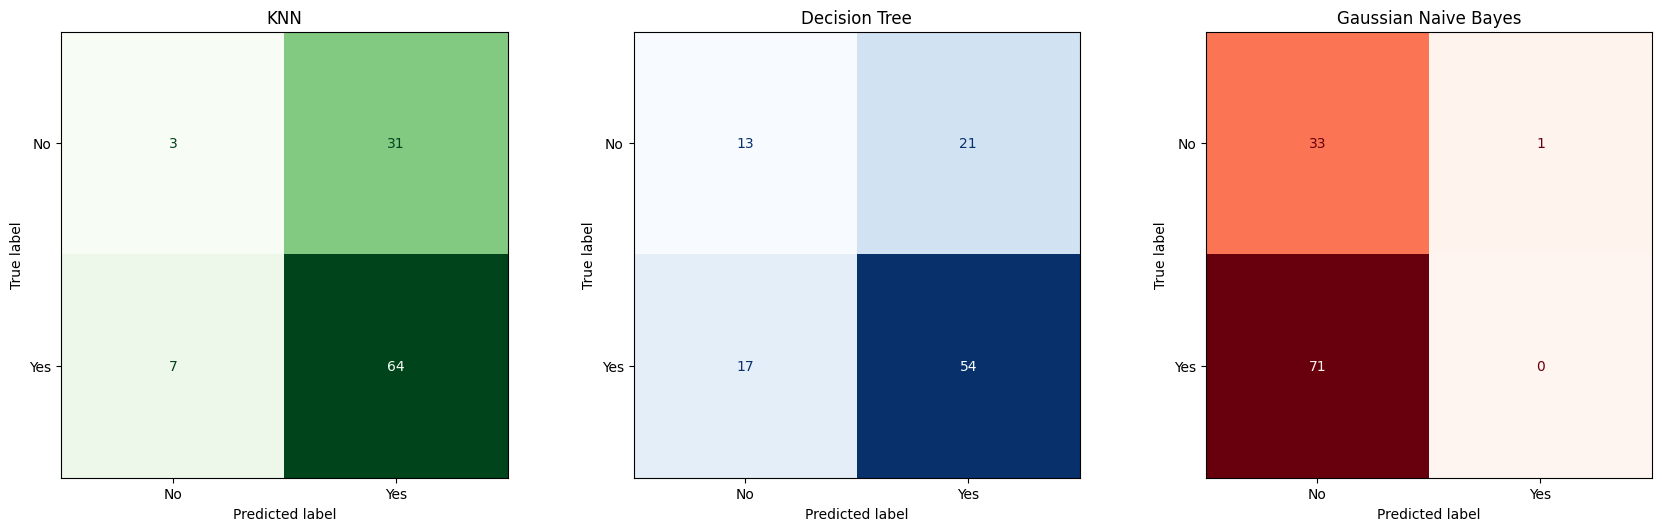

In [133]:
results = eval_dataset('Trimmed')

display(pd.DataFrame.from_dict(results).drop(columns = ['confusion_matrix']))
print_confusion_matrix(results)

##### Evaluación de `filled_dataset`

,algorithm,accuracy,precision_n,precision_y,recall_n,recall_y
0,KNeighborsClassifier,0.626168,0.444444,0.642857,0.102564,0.926471
1,DecisionTreeClassifier,0.579439,0.411765,0.657534,0.358974,0.705882
2,GaussianNB,0.626168,0.428571,0.640000,0.076923,0.941176


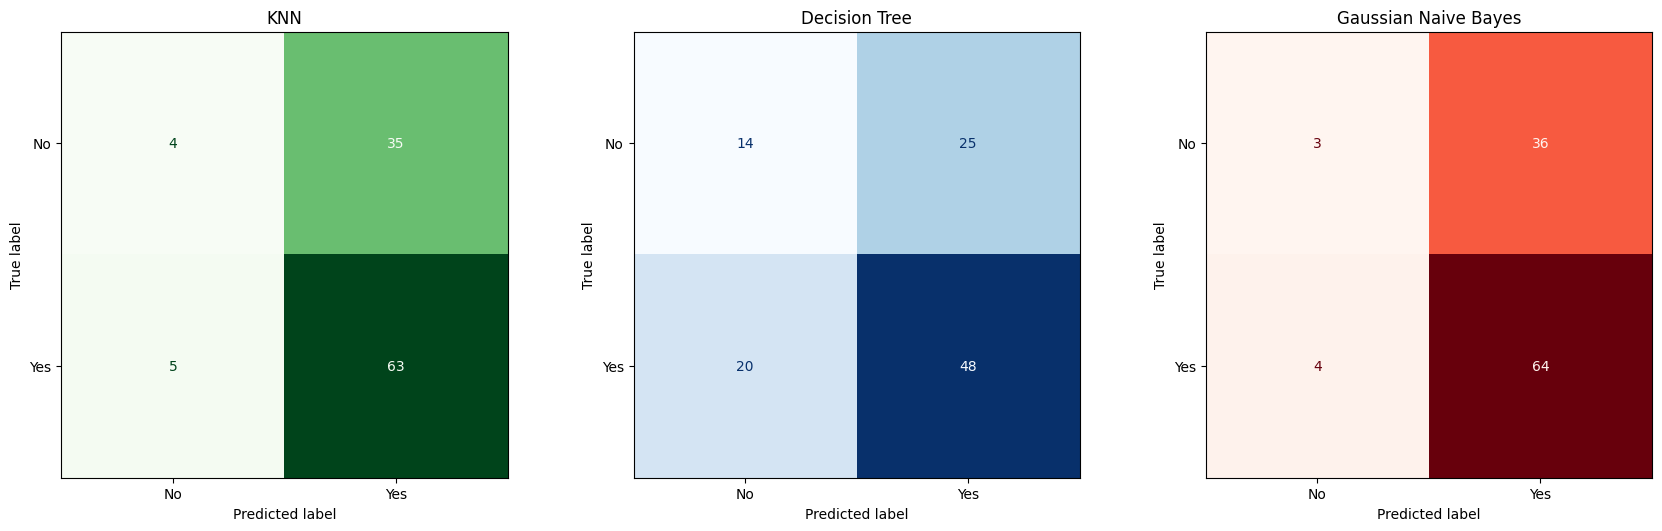

In [134]:
results = eval_dataset('Filled')

display(pd.DataFrame.from_dict(results).drop(columns = ['confusion_matrix']))
print_confusion_matrix(results)

##### Evaluación de `trimmed_dataset_balanced`

,algorithm,accuracy,precision_n,precision_y,recall_n,recall_y
0,KNeighborsClassifier,0.590476,0.404255,0.741379,0.558824,0.605634
1,DecisionTreeClassifier,0.495238,0.313725,0.666667,0.470588,0.507042
2,GaussianNB,0.323810,0.316832,0.500000,0.941176,0.028169


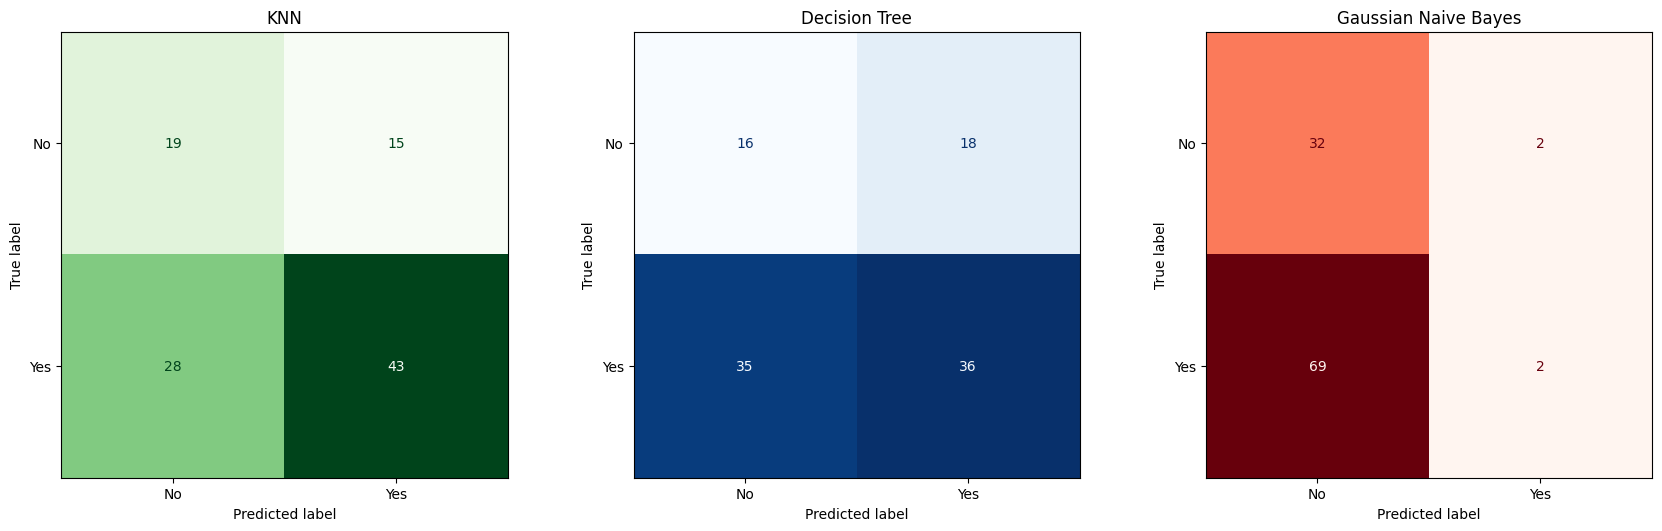

In [135]:
results = eval_dataset('Trimmed Balanced')

display(pd.DataFrame.from_dict(results).drop(columns = ['confusion_matrix']))
print_confusion_matrix(results)

##### Evaluación de `filled_dataset_bal`

,algorithm,accuracy,precision_n,precision_y,recall_n,recall_y
0,KNeighborsClassifier,0.504673,0.333333,0.615385,0.358974,0.588235
1,DecisionTreeClassifier,0.588785,0.456140,0.740000,0.666667,0.544118
2,GaussianNB,0.570093,0.425532,0.683333,0.512821,0.602941


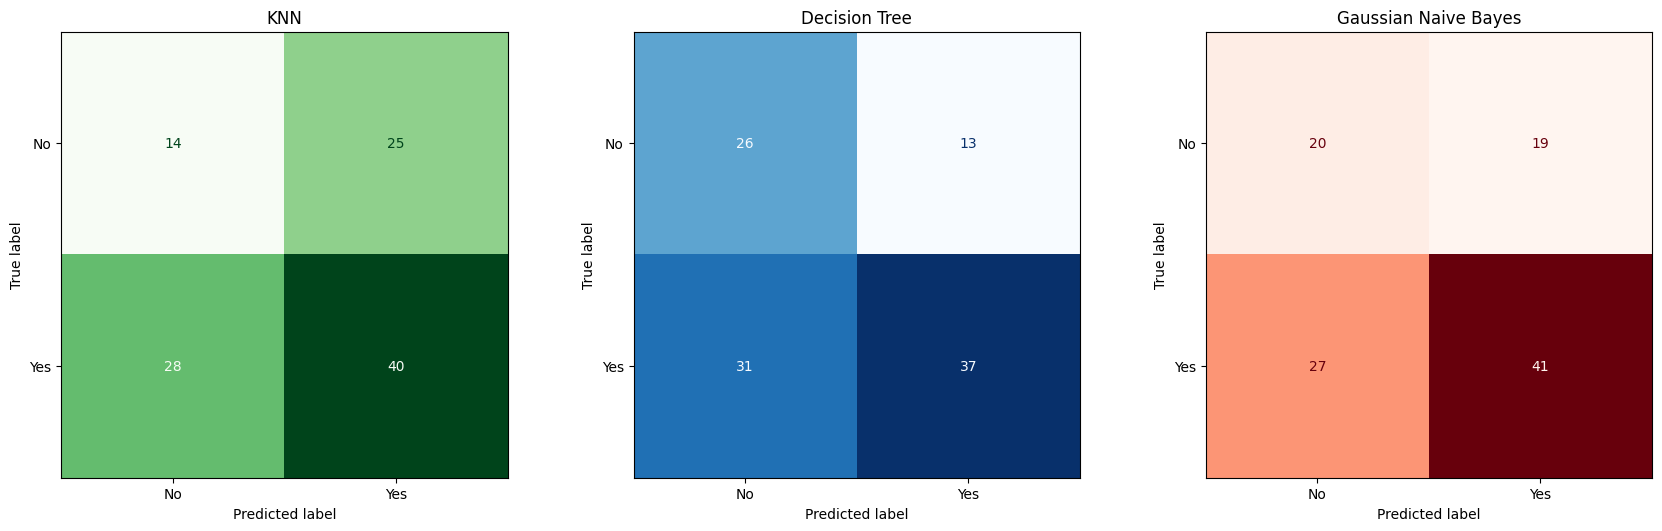

In [136]:
results = eval_dataset('Filled Balanced')

display(pd.DataFrame.from_dict(results).drop(columns = ['confusion_matrix']))
print_confusion_matrix(results)

## Conclusiones extraídas

Los resultados obtenidos en el proyecto son bastante precarios, pues ninguno de
los clasificadores entrenados ha obtenido exactitudes _(accuracy)_ superiores al
65%, lo que puede indicar que el modelo no es capaz de generalizar bien los
datos.

Analizando los resultados por conjunto, podemos observar que aquellos conjuntos
con información sin procesar (`trimmed_dataset` y su versión balanceada 
`trimmed_dataset_balanced`) obtienen mejores _accuracies_ que aquellos conjuntos
con información preprocesada (`filled_dataset` y su versión balanceada
`filled_dataset_bal`). Sin embargo, los valores de _recall_ y _precision_
tienden a ser más polares en los conjuntos sin procesar que en los procesados,
que son más estables.

Observando las matrices de confusión, podemos percibir resultados muy similares
entre los conjuntos sin procesar y los procesados, sobre todo con los algoritmos
**KNN** y **Árbol de clasificación**. Sin embargo, el algoritmo **Naive Bayes**
obtiene predicciones opuestas entre ambos conjuntos. No se puede distinguir
ninguna diagonal marcada en ninguna matriz de confusión, por lo que incluso sin
analizar los valores de _accuracy_, se puede observar que el modelo no es capaz
de generalizar bien los datos.

Como futuras mejoras al modelo para buscar mejores resultados, se podría analizar
qué variables son las que más influyen en la predicción, y eliminar aquellas que
no aporten información relevante al modelo. Además, se podrían generar variables
_dummy_ para aquellas variables cualitativas que no sean binarias, para que el
modelo pueda trabajar con ellas de forma más eficiente. También podría ser
interesante el análisis de los _outliers_ para ver si los datos eliminados
fueran realmente _outliers_, o si por el contrario se han eliminado valores
válidos para el modelo.